In [31]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn.hmm import MultinomialHMM

## Keystroke Dynamics Dataset Schema

All timing values are in **seconds** (floating-point). Each row corresponds to one repetition of the password `.tie5Roanl` by a single subject.

| Column name       | Type    | Description |
|-------------------|---------|-------------|
| `subject`         | string  | Unique subject ID (e.g., `s002`, `s057`). Identifies the typist. |
| `sessionIndex`    | int     | Session number in which the password was typed (1–8). |
| `rep`             | int     | Repetition index of the password within the session (1–50). |

### Per-key hold times (`H.*`)

| Column name   | Type   | Description |
|---------------|--------|-------------|
| `H.period`    | float  | Hold time of the `.` key (key down → key up). |
| `H.t`         | float  | Hold time of the `t` key. |
| `H.i`         | float  | Hold time of the `i` key. |
| `H.e`         | float  | Hold time of the `e` key. |
| `H.five`      | float  | Hold time of the `5` key. |
| `H.Shift.r`   | float  | Hold time of the right Shift key (used to type uppercase `R`). |
| `H.o`         | float  | Hold time of the `o` key. |
| `H.a`         | float  | Hold time of the `a` key. |
| `H.n`         | float  | Hold time of the `n` key. |
| `H.l`         | float  | Hold time of the `l` key. |
| `H.Return`    | float  | Hold time of the Return/Enter key pressed after the password. |

### Keydown–keydown latencies (`DD.*.*`)

`DD.key1.key2` = time from **keydown of key1** to **keydown of key2**.

| Column name        | Type   | Description |
|--------------------|--------|-------------|
| `DD.period.t`      | float  | Time from pressing `.` to pressing `t`. |
| `DD.t.i`           | float  | Time from pressing `t` to pressing `i`. |
| `DD.i.e`           | float  | Time from pressing `i` to pressing `e`. |
| `DD.e.five`        | float  | Time from pressing `e` to pressing `5`. |
| `DD.five.Shift.r`  | float  | Time from pressing `5` to pressing right Shift. |
| `DD.Shift.r.o`     | float  | Time from pressing right Shift to pressing `o`. |
| `DD.o.a`           | float  | Time from pressing `o` to pressing `a`. |
| `DD.a.n`           | float  | Time from pressing `a` to pressing `n`. |
| `DD.n.l`           | float  | Time from pressing `n` to pressing `l`. |
| `DD.l.Return`      | float  | Time from pressing `l` to pressing Return. |

### Keyup–keydown latencies (`UD.*.*`)

`UD.key1.key2` = time from **keyup of key1** to **keydown of key2**.  
These values can be **negative** (if key2 is pressed before key1 is released).  
Note: `H(key1) + UD(key1,key2) = DD(key1,key2)`.

| Column name        | Type   | Description |
|--------------------|--------|-------------|
| `UD.period.t`      | float  | Time from releasing `.` to pressing `t`. |
| `UD.t.i`           | float  | Time from releasing `t` to pressing `i`. |
| `UD.i.e`           | float  | Time from releasing `i` to pressing `e`. |
| `UD.e.five`        | float  | Time from releasing `e` to pressing `5`. |
| `UD.five.Shift.r`  | float  | Time from releasing `5` to pressing right Shift. |
| `UD.Shift.r.o`     | float  | Time from releasing right Shift to pressing `o`. |
| `UD.o.a`           | float  | Time from releasing `o` to pressing `a`. |
| `UD.a.n`           | float  | Time from releasing `a` to pressing `n`. |
| `UD.n.l`           | float  | Time from releasing `n` to pressing `l`. |
| `UD.l.Return`      | float  | Time from releasing `l` to pressing Return. |


In [32]:
keystroke_data = pd.read_csv("data/DSL-StrongPasswordData.csv")

In [33]:
keystroke_data.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Lets do some basic checks to ensure the data is valid:

In [34]:
# Basic checks on keystroke_data to verify soundness

# 1. Check for missing values
num_missing = keystroke_data.isnull().sum().sum()
print(f"Total missing values: {num_missing}\n")

# 2. Check shape: should have expected rows and columns (should have 34 columns: 3 meta + 31 features)
print(f"Shape: {keystroke_data.shape}\n")

hold_cols = [col for col in keystroke_data.columns if col.startswith("H.")]
dd_cols = [col for col in keystroke_data.columns if col.startswith("DD.")]
ud_cols = [col for col in keystroke_data.columns if col.startswith("UD.")]

# 4. Ensure every subject/session/rep combination is unique
duplicates = keystroke_data.duplicated(subset=['subject', 'sessionIndex', 'rep']).sum()
print(f"Duplicate subject/session/rep rows: {duplicates}\n")

# 5. Print out basic statistics for all feature columns
print("Timing feature statistics:")
print(keystroke_data[hold_cols + dd_cols + ud_cols].describe().T[["min", "25%", "50%", "75%", "max"]])



Total missing values: 0

Shape: (20400, 34)

Duplicate subject/session/rep rows: 0

Timing feature statistics:
                    min       25%      50%       75%      max
H.period         0.0014  0.074400  0.08950  0.107900   0.3761
H.t              0.0093  0.066000  0.08100  0.099800   0.2411
H.i              0.0032  0.062000  0.07710  0.096900   0.3312
H.e              0.0021  0.068600  0.08340  0.102700   0.3254
H.five           0.0014  0.061000  0.07420  0.090600   0.1989
H.Shift.r        0.0014  0.070200  0.09350  0.116700   0.2817
H.o              0.0069  0.071500  0.08630  0.101900   0.6872
H.a              0.0040  0.082100  0.10190  0.122300   2.0353
H.n              0.0037  0.067300  0.08530  0.107900   0.3577
H.l              0.0037  0.077400  0.09370  0.111100   0.3407
H.Return         0.0029  0.069900  0.08550  0.103700   0.2651
DD.period.t      0.0187  0.146900  0.20595  0.306450  12.5061
DD.t.i           0.0011  0.113600  0.14040  0.183900   4.9197
DD.i.e           0.00

### EDA and Visualization:

Summary statistics and distributions of timing features


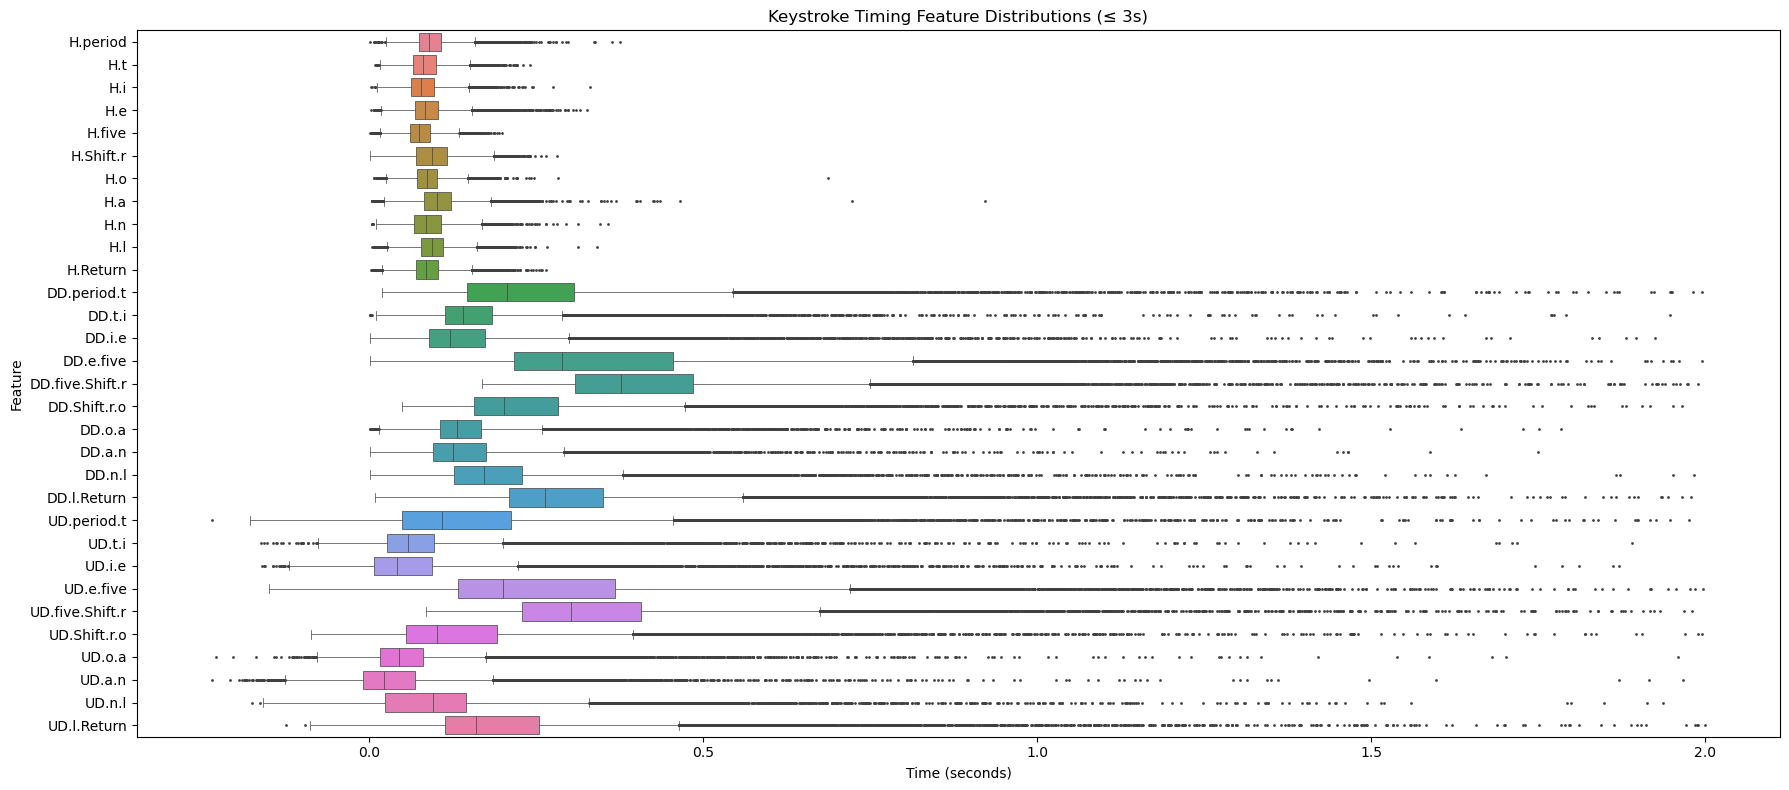

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distributions of timing features
feature_cols = hold_cols + dd_cols + ud_cols

# Remove outliers over 3 seconds in any feature
filtered_keystroke_data = keystroke_data.copy()
filtered_keystroke_data[feature_cols] = filtered_keystroke_data[feature_cols].where(filtered_keystroke_data[feature_cols] <= 2)

# Draw plot
plt.figure(figsize=(18, 8))  
sns.boxplot(data=filtered_keystroke_data[feature_cols], orient="h", fliersize=1, linewidth=0.5)
plt.title("Keystroke Timing Feature Distributions (≤ 3s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Note: Up/Down timings can be negative if both keys are pressed at the same time 

Distributions of a few individual timing features:


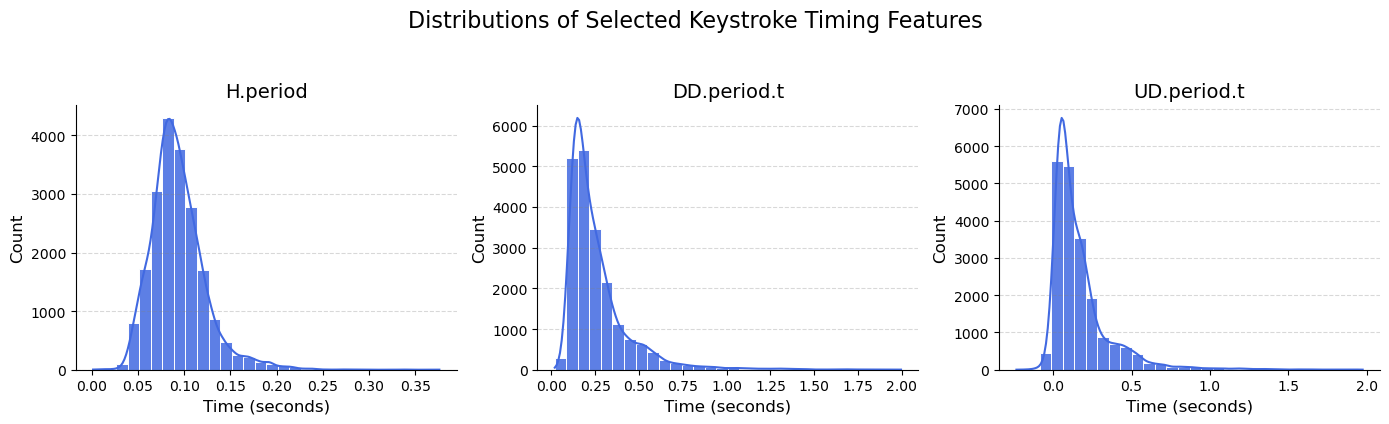

In [36]:

single_columns_to_plot = [
    'H.period', 'DD.period.t', 'UD.period.t',
]

plt.figure(figsize=(14, 4))
for i, col in enumerate(single_columns_to_plot, 1):
    ax = plt.subplot(1, 3, i)
    sns.histplot(
        filtered_keystroke_data[col],
        bins=30,
        kde=True,
        color="royalblue",
        linewidth=0.7,
        edgecolor="white",
        alpha=0.85,
        ax=ax
    )
    ax.set_title(f"{col}", fontsize=14,)
    ax.set_xlabel("Time (seconds)", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.grid(axis='y', linestyle='--', color='grey', alpha=0.3, zorder=0)
    # Remove right/top spines for a cleaner look
    sns.despine(ax=ax)

plt.suptitle("Distributions of Selected Keystroke Timing Features", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



With the data validated and distributions explored, we're ready to move on to the preprocessing stage.

## 1. From Keystrokes to Observation Sequences

Firstly, we need to discretize our data into a form that is easily digestable for an HMM.

This is the current state of each observation:

In [37]:
pd.DataFrame(keystroke_data.iloc[0])

,0
subject,s002
sessionIndex,1
rep,1
H.period,0.1491
DD.period.t,0.3979
UD.period.t,0.2488
H.t,0.1069
DD.t.i,0.1674
UD.t.i,0.0605
H.i,0.1169


Each row in the dataset corresponds to **one repetition of the same password** (e.g. `.tie5Roanl`) typed by some subject.

The observations look like:

- Metadata: `subject`, `sessionIndex`, `rep`
- Timing features (31 columns):
  - Hold times: `H.period`, `H.t`, …, `H.Return`
  - Keydown–keydown times: `DD.period.t`, `DD.t.i`, …, `DD.l.Return`
  - Keyup–keydown times: `UD.period.t`, `UD.t.i`, …, `UD.l.Return`

So for one repetition, we have a vector of 31 timing values:

$$
\mathbf{x} = (x_1, x_2, \dots, x_T), \quad T \approx 31.
$$

We then **discretize** each continuous timing value into a small number of bins:

- Collect all timing values across the dataset.
- Use quantile-based binning into $m$ bins (e.g. $m = 10$).
- This means that the bins are constructed such that roughly $\frac{1}{m}$ of all observed timings in the dataset fall within each bin.
- For each feature $x_t$, map it to a bin index:
  $$
  O_t \in \{0, 1, \dots, m-1\}.
  $$

So **one password repetition** becomes a sequence of discrete observations:

$$
\mathbf{o} = (o_1, o_2, \dots, o_T), \quad o_t \in \{0,\dots,m-1\}.
$$

Each user has many such sequences (up to ~400 repetitions).

---

In [38]:
def build_sequences_discrete(
    df: pd.DataFrame,
    n_bins: int = 10,
    min_reps_per_subject: int = 20,
) -> Tuple[Dict[str, List[np.ndarray]], int, KBinsDiscretizer]:
    """
    Build per-subject sequences of discrete symbols for each repetition.

    Each row = one password repetition for some subject.
    For that row:
      - We have 31 timing features (H.*, DD.*, UD.*, ...).
      - Each timing value is discretized via global quantile bins into {0,...,n_bins-1}.
      - The sequence is the length-31 vector of symbols for that repetition.

    Returns:
        subject_to_sequences: dict[subject -> list of np.array(T,) of ints], T = #timing cols
        n_obs: number of discrete symbols (n_bins)
        discretizer: fitted KBinsDiscretizer (for consistency if you transform new data)
    """
    meta_cols = ["subject", "sessionIndex", "rep"]
    feature_cols = [c for c in df.columns if c not in meta_cols]

    # Flatten all timing values into a single vector for global quantile binning
    all_values = df[feature_cols].to_numpy(dtype=float).reshape(-1, 1)

    discretizer = KBinsDiscretizer(
        n_bins=n_bins,
        encode="ordinal",
        strategy="quantile",
    )
    discretizer.fit(all_values)

    subject_to_sequences: Dict[str, List[np.ndarray]] = {}

    for subj, df_subj in df.groupby("subject"):
        df_subj = df_subj.sort_values(by=["sessionIndex", "rep"])
        if len(df_subj) < min_reps_per_subject:
            continue

        seqs: List[np.ndarray] = []
        for _, row in df_subj.iterrows():
            vals = row[feature_cols].to_numpy(dtype=float).reshape(-1, 1)  # (31,1)
            symbols = discretizer.transform(vals).astype(int).ravel()      # (31,)
            seqs.append(symbols)

        if seqs:
            subject_to_sequences[subj] = seqs

        
    
    # return the sequences, the number of bins, and the discretizer for consistency during prediction.
    return subject_to_sequences, n_bins, discretizer

In [39]:
subject002 = pd.DataFrame(build_sequences_discrete(keystroke_data, n_bins=10, min_reps_per_subject=20)[0]).T.iloc[[0]]
subject002

/opt/miniconda3/envs/datasci-sec/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
s002,"[6, 9, 8, 4, 6, 1, 5, 7, 4, 6, 9, 9, 5, 9, 9, ...","[5, 8, 8, 2, 5, 1, 3, 6, 1, 3, 9, 9, 2, 9, 9, ...","[6, 7, 2, 2, 5, 1, 3, 6, 2, 3, 9, 9, 3, 9, 9, ...","[5, 8, 5, 4, 8, 6, 4, 7, 4, 3, 9, 9, 3, 9, 9, ...","[5, 8, 4, 3, 7, 2, 3, 6, 2, 3, 9, 9, 2, 9, 9, ...","[6, 8, 4, 3, 5, 1, 2, 6, 2, 3, 9, 9, 4, 9, 9, ...","[4, 7, 4, 3, 6, 1, 2, 6, 1, 2, 9, 9, 3, 9, 9, ...","[3, 7, 3, 3, 6, 1, 2, 6, 1, 2, 9, 9, 6, 9, 9, ...","[4, 7, 3, 2, 5, 1, 3, 6, 1, 2, 9, 9, 2, 9, 9, ...","[4, 7, 2, 2, 6, 2, 2, 5, 1, 3, 9, 9, 3, 9, 9, ...",...,"[6, 7, 1, 5, 7, 1, 5, 4, 0, 5, 8, 7, 6, 9, 9, ...","[6, 6, 0, 5, 6, 0, 5, 5, 0, 5, 8, 6, 6, 9, 9, ...","[6, 8, 3, 5, 9, 8, 6, 7, 1, 5, 8, 7, 6, 9, 8, ...","[6, 7, 1, 5, 7, 1, 5, 6, 0, 6, 8, 4, 6, 9, 9, ...","[6, 7, 1, 5, 5, 0, 6, 7, 1, 6, 8, 5, 6, 9, 8, ...","[6, 7, 1, 1, 5, 2, 4, 5, 0, 3, 8, 6, 4, 9, 9, ...","[7, 8, 1, 5, 7, 2, 4, 6, 0, 4, 9, 9, 5, 9, 9, ...","[6, 7, 0, 3, 5, 0, 5, 6, 0, 3, 8, 6, 6, 9, 9, ...","[6, 7, 1, 3, 7, 4, 6, 7, 2, 5, 9, 8, 6, 9, 9, ...","[7, 7, 0, 5, 6, 1, 6, 6, 0, 4, 9, 9, 4, 9, 9, ..."


Now, for each user, we have discretized the timing of their keystrokes into bins.

A full example of how the observations from one password entry will be broken down for the HMM:

For a single time step $t$, if we use $n_{\text{bins}} = 10$ and the discretized bin is $o_t = 3$, then the **one-hot binned observation vector** $\mathbf{x}_t$ looks like:

$$
\mathbf{x}_t = [\,0,\ 0,\ 0,\ 1,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0\,].
$$

Index-by-index (0-based):

- bin 0 $\rightarrow$ 0  
- bin 1 $\rightarrow$ 0  
- bin 2 $\rightarrow$ 0  
- bin 3 $\rightarrow$ 1  (this matches $o_t = 3$)  
- bin 4 $\rightarrow$ 0  
- bin 5 $\rightarrow$ 0  
- bin 6 $\rightarrow$ 0  
- bin 7 $\rightarrow$ 0  
- bin 8 $\rightarrow$ 0  
- bin 9 $\rightarrow$ 0  

For a full password repetition of length $T \approx 31$, suppose the sequence of bins is

$$
\mathbf{o} = [\,3,\ 5,\ 1,\ 7,\ 2,\ \dots\,].
$$

The corresponding one-hot matrix $X$ (what the HMM actually sees) is:

$$
X =
\begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}.
$$

Each row of $X$ is the one-hot vector $\mathbf{x}_t$ for one time step $t$, and each column corresponds to one timing bin (0 through 9).


In [40]:
def sequences_to_one_hot(
    seqs: List[np.ndarray],
    n_obs: int,
) -> Tuple[np.ndarray, List[int]]:
    """
    Convert a list of integer sequences into a one-hot matrix + lengths.

    seqs: list of arrays of shape (T,) with integers in [0, n_obs-1]
    Returns:
        X: (sum_T, n_obs) one-hot, dtype=int
        lengths: list of T for each sequence
    """
    eye = np.eye(n_obs, dtype=int)
    one_hot_blocks = []
    lengths = []

    for s in seqs:
        s = np.asarray(s, dtype=int)
        one_hot = eye[s]             # (T, n_obs), still int
        one_hot_blocks.append(one_hot)
        lengths.append(len(s))

    X = np.concatenate(one_hot_blocks, axis=0)  # (sum_T, n_obs), int
    return X, lengths

One hot encoding example:

In [41]:
subject002_seqs = list(subject002.values.flatten())
subject002_one_hot = sequences_to_one_hot(subject002_seqs, n_obs=10)
subject002_one_hot[0]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

Now that we have our data preprocessed and ready for ML, we can focus on the HMM.

# Hidden Markov Model for Keystroke Dynamics Authentication

This section explains, in mathematical and intuitive terms, how the Hidden Markov Model (HMM) we built works for keystroke-based user authentication. The notation matches the standard HMM notation:

- Hidden states: $S_t$
- Observations: $O_t$
- Initial distribution: $\pi$
- Transition matrix: $A$
- Emission matrix: $B$
- Forward variables: $\alpha$
- Backward variables: $\beta$
- Posteriors: $\gamma, \xi$

---

## 2. HMM for a Single User

For each user $u$, we train a **separate HMM**:

- Hidden state at time $t$: $S_t \in \{1,\dots,n\}$
  - Interpret these as latent **typing modes** for that user (e.g. “steady”, “rushing”, “hesitating”).
- Observation at time $t$: $O_t \in \{0,\dots,m-1\}$
  - The discretized timing bin for feature $t$.

The HMM parameters for user $u$ (we drop the superscript $(u)$ for readability) are:

- Initial state distribution
  $$
  \pi_i = P(S_1 = i), \quad i = 1,\dots,n.
  $$
- Transition probabilities
  $$
  a_{ij} = P(S_{t+1} = j \mid S_t = i), \quad i,j = 1,\dots,n.
  $$
- Emission probabilities
  $$
  b_{ik} = P(O_t = k \mid S_t = i), \quad i = 1,\dots,n,\; k = 0,\dots,m-1.
  $$

We write these as:

- $\boldsymbol{\pi} = (\pi_1,\dots,\pi_n)$
- $A = [a_{ij}]_{i,j=1}^n$
- $B = [b_{ik}]_{\substack{i=1,\dots,n \\ k=0,\dots,m-1}}$

---


## 3. Generative Story and Joint Probability

The HMM defines a **generative process** for a sequence:

1. Sample initial hidden state:
   $$
   S_1 \sim (\pi_1,\dots,\pi_n).
   $$

2. Emit first observation:
   $$
   O_1 \sim (b_{1,o_1}, \dots, b_{n,o_1}) \text{ conditioned on } S_1.
   $$

3. For each time step $t = 1,\dots,T-1$:
   - Transition:
     $$
     S_{t+1} \sim (a_{S_t,1},\dots,a_{S_t,n}).
     $$
   - Emission:
     $$
     O_{t+1} \sim (b_{S_{t+1},0},\dots,b_{S_{t+1},m-1}).
     $$

Under the Markov and conditional-independence assumptions, the **joint probability** of a state sequence $\mathbf{s} = (s_1,\dots,s_T)$ and an observation sequence $\mathbf{o} = (o_1,\dots,o_T)$ is:

$$
\begin{aligned}
P(\mathbf{s}, \mathbf{o})
&= P(S_1 = s_1)\,P(O_1 = o_1 \mid S_1 = s_1)\,\prod_{t=1}^{T-1} P(S_{t+1} = s_{t+1} \mid S_t = s_t)\,P(O_{t+1} = o_{t+1} \mid S_{t+1} = s_{t+1}) \\
&= \pi_{s_1} \, b_{s_1,o_1} \, \prod_{t=1}^{T-1} a_{s_t,s_{t+1}}\, b_{s_{t+1},o_{t+1}}.
\end{aligned}
$$

The **likelihood** of the observed sequence under the model is obtained by summing over all hidden paths:

$$
P(\mathbf{o}) = \sum_{s_1,\dots,s_T} P(\mathbf{s}, \mathbf{o}).
$$

We will make use of maximizing this likelihood later.

---


## 4. Discrete Multinomial HMM

The new `MultinomialHMM` interprets observations at each time step as **count vectors**:

- For $m$ possible symbols, an observation at time $t$ is a vector:
  $$
  \mathbf{x}_t \in \mathbb{N}^m,\quad \sum_{k=1}^m x_{t,k} = \text{n\_trials}.
  $$

We want a **categorical** distribution over symbols $\{0,\dots,m-1\}$. We achieve this by:

- Setting `n_trials = 1`.
- Representing a symbol $o_t$ as a **one-hot vector**:
  $$
  \mathbf{x}_t = \text{one\_hot}(o_t) \in \{0,1\}^m,
  \quad \sum_k x_{t,k} = 1.
  $$

For hidden state $i$, the emission parameters are:

$$
\mathbf{b}_i = (b_{i0}, b_{i1}, \dots, b_{i,m-1}),
\quad \sum_{k=0}^{m-1} b_{ik} = 1.
$$

Then the emission probability is:

$$
P(\mathbf{x}_t \mid S_t = i)
= \text{Multinomial}(\mathbf{x}_t; \text{n\_trials}=1, \mathbf{b}_i)
= b_{i, o_t}.
$$

So the `MultinomialHMM` with one-hot counts and `n_trials = 1` is exactly a **categorical observation model**.

---


## 5. Forward Algorithm: Computing $P(\mathbf{o})$

Define the **forward variables**:

$$
\alpha_{i t} = P(o_1, \dots, o_t, S_t = i), \quad i = 1,\dots,n,\; t = 1,\dots,T.
$$

Intuition: $\alpha_{i t}$ is the probability that after observing the first $t$ timing bins, the HMM is in hidden state $i$ and has produced exactly those observations.

### Initialization ($t = 1$)

$$
\alpha_{i 1}
= P(S_1 = i, o_1)
= \pi_i \, b_{i, o_1}.
$$

### Recurrence ($t = 1,\dots,T-1$)

$$
\alpha_{j, t+1}
= P(o_1,\dots,o_{t+1}, S_{t+1} = j)
= \sum_{i=1}^n \alpha_{i t} \, a_{i j} \, b_{j, o_{t+1}}.
$$

This is a dynamic program: each column of the $\alpha$-table is computed from the previous one.

### Likelihood

Once we reach time $T$:

$$
P(\mathbf{o})
= P(o_1,\dots,o_T)
= \sum_{i=1}^n \alpha_{i T}.
$$

In practice, we work in **log space** and use scaling to avoid underflow. The library’s `score()` function is computing (a scaled version of) this log-likelihood.

---


## 6. Backward Algorithm and Posteriors

For EM learning, we also need the **backward variables**:

$$
\beta_{i t} = P(o_{t+1}, \dots, o_T \mid S_t = i).
$$

Intuition: $\beta_{i t}$ is the probability of generating the tail of the sequence starting from state $i$ at time $t$.

### Initialization ($t = T$)

$$
\beta_{i T} = 1, \quad \forall i.
$$

### Recurrence ($t = T-1,\dots,1$)

$$
\beta_{i t}
= \sum_{j=1}^n a_{i j} \, b_{j, o_{t+1}} \, \beta_{j, t+1}.
$$

Given both $\alpha$ and $\beta$, we can compute **posterior probabilities** over states and transitions.

#### State posterior ($\gamma$)

$$
\gamma_{i t}
= P(S_t = i \mid \mathbf{o})
= \frac{\alpha_{i t}\,\beta_{i t}}{\sum_{k=1}^n \alpha_{k t}\,\beta_{k t}}.
$$

Interpretation: probability that we were in mode $i$ at time $t$ given the whole sequence.

#### Transition posterior ($\xi$)

$$
\xi_{i j, t}
= P(S_t = i, S_{t+1} = j \mid \mathbf{o})
= \frac{\alpha_{i t}\, a_{i j} \, b_{j, o_{t+1}} \, \beta_{j, t+1}}
       {\sum_{k=1}^n \sum_{\ell=1}^n \alpha_{k t}\, a_{k \ell} \, b_{\ell, o_{t+1}} \, \beta_{\ell, t+1}}.
$$

These $\gamma_{i t}$ and $\xi_{i j, t}$ are the “soft counts” of how often each state and transition is used, conditioned on the data.

---

## 7. EM Learning for One User

For a single user, we have many repetition sequences:

$$
\{\mathbf{o}^{(r)}\}_{r=1}^R, \quad \mathbf{o}^{(r)} = (o^{(r)}_1,\dots,o^{(r)}_{T_r}).
$$

We want to find parameters $\theta = (\boldsymbol{\pi}, A, B)$ that **maximize the likelihood**:

$$
\theta^* = \arg\max_\theta \sum_{r=1}^R \log P(\mathbf{o}^{(r)} \mid \theta).
$$

This is done using **EM**, known as the **Baum–Welch algorithm** for HMMs.

### E-step

For each sequence $\mathbf{o}^{(r)}$:

1. Run forward–backward to get $\alpha^{(r)}_{i t}$, $\beta^{(r)}_{i t}$.
2. Compute:
   - $\gamma^{(r)}_{i t} = P(S^{(r)}_t = i \mid \mathbf{o}^{(r)})$.
   - $\xi^{(r)}_{i j, t} = P(S^{(r)}_t = i, S^{(r)}_{t+1} = j \mid \mathbf{o}^{(r)})$.

### M-step

Update parameters by treating these posteriors as expected counts.

1. **Initial distribution**:
   $$
   \pi_i \leftarrow
   \frac{1}{R} \sum_{r=1}^R P(S_1^{(r)} = i \mid \mathbf{o}^{(r)})
   = \frac{1}{R} \sum_{r=1}^R \gamma^{(r)}_{i 1}.
   $$

2. **Transition probabilities**:
   $$
   a_{i j} \leftarrow
   \frac
     {\sum_{r=1}^R \sum_{t=1}^{T_r - 1} \xi^{(r)}_{i j, t}}
     {\sum_{r=1}^R \sum_{t=1}^{T_r - 1} \gamma^{(r)}_{i t}}.
   $$

3. **Emission probabilities**:
   $$
   b_{i k} \leftarrow
   \frac
     {\sum_{r=1}^R \sum_{t=1}^{T_r} \mathbf{1}\{o^{(r)}_t = k\} \, \gamma^{(r)}_{i t}}
     {\sum_{r=1}^R \sum_{t=1}^{T_r} \gamma^{(r)}_{i t}}.
   $$

Then repeat E-step and M-step until convergence (or until hitting a max iteration cap). The `MultinomialHMM.fit()` call is performing this EM loop internally.

---

## 8. Identification / Authentication with Multiple User Models

We now have **one HMM per user**:

$$
\theta^{(u)} = (\boldsymbol{\pi}^{(u)}, A^{(u)}, B^{(u)}),\quad u \in \mathcal{U}.
$$

Given a new keystroke sequence $\mathbf{o}$ (timings for one password repetition), we compute:

$$
\log P(\mathbf{o} \mid \theta^{(u)}) \quad \text{for each user } u.
$$

If we assume a uniform prior over users, the **MAP estimate** of the user is:

$$
\hat{u} = \arg\max_{u \in \mathcal{U}} \log P(\mathbf{o} \mid \theta^{(u)}).
$$

This is exactly what the evaluation code does:

1. Convert the raw timings for that repetition into a discretized sequence $\mathbf{o}$.
2. For each user’s trained `MultinomialHMM`, call `score()` to compute the log-likelihood.
3. Pick the user with the highest log-likelihood as the predicted identity.

If we do this on a test set of repetitions, we can measure **identification accuracy**:

$$
\text{Accuracy} = \frac{\# \text{correctly identified repetitions}}{\# \text{total test repetitions}}.
$$

---

## 9. Intuition: What the HMM Learns About Typing

- The hidden states $S_t$ capture **latent typing modes**:
  - e.g. “smooth flow”, “small hesitation”, “big hesitation / correction”.
- The transition matrix $A$ captures how a user tends to **move between modes** as they type:
  - e.g. staying mostly in a steady mode, occasionally jumping to a “slow” mode at certain keys.
- The emission matrix $B$ captures, for each mode, the **distribution over timing bins**:
  - e.g. in one state, most timing bins are low (fast); in another, bins are higher (slow).

Because these patterns are **user-specific**, the combination of $(\boldsymbol{\pi}, A, B)$ becomes a kind of **probabilistic signature** of that user’s typing behavior. When a new sequence of timings is more likely under one user’s HMM than others, the model uses that to **verify or identify** the user.


# Putting it all together:

To evaluate our model fairly and tune its hyperparameters, we first split our dataset for each user into separate **training, validation, and testing sets**. This ensures that the model is assessed on unseen data and helps prevent overfitting. We'll begin by creating these splits before proceeding to train our user-specific HMMs.

In [42]:
def train_val_test_split_sequences(
    subject_to_sequences: Dict[str, List[np.ndarray]],
    train_frac: float = 0.7,
    val_frac: float = 0.15,
    random_state: int = 0,
) -> Tuple[
    Dict[str, List[np.ndarray]],
    Dict[str, List[np.ndarray]],
    Dict[str, List[np.ndarray]],
]:
    """Split sequences per subject into train/val/test dictionaries.

    Each subject's list of sequences is shuffled with the provided random seed,
    then split by fractions. The test set receives the remainder after
    train and validation splits.

    Args:
        subject_to_sequences: Mapping from subject id to list of sequences (np.ndarray).
        train_frac: Fraction of sequences per subject to use for training.
        val_frac: Fraction of sequences per subject to use for validation.
        random_state: Seed for reproducible shuffling.

    Returns:
        (train_dict, val_dict, test_dict)
    """
    if not (0.0 <= train_frac <= 1.0 and 0.0 <= val_frac <= 1.0):
        raise ValueError("train_frac and val_frac must be in [0, 1].")
    if train_frac + val_frac >= 1.0:
        raise ValueError("train_frac + val_frac must be < 1.0 to leave room for test set.")

    rng = np.random.default_rng(random_state)

    train_dict: Dict[str, List[np.ndarray]] = {}
    val_dict: Dict[str, List[np.ndarray]] = {}
    test_dict: Dict[str, List[np.ndarray]] = {}

    for subject_id, sequences in subject_to_sequences.items():
        seqs = list(sequences)
        rng.shuffle(seqs)

        n_total = len(seqs)
        n_train = int(n_total * train_frac)
        n_val = int(n_total * val_frac)

        # Guard against rounding issues on very small per-subject datasets
        n_train = min(n_train, n_total)
        n_val = min(n_val, max(0, n_total - n_train))

        train_dict[subject_id] = seqs[:n_train]
        val_dict[subject_id] = seqs[n_train:n_train + n_val]
        test_dict[subject_id] = seqs[n_train + n_val:]

    return train_dict, val_dict, test_dict


### Training:
Now, we train a separate discrete Hidden Markov Model (HMM) for each user. 
These models will later be used to assign user identity to unseen data by comparing 
how well each model explains new sequences.

In [43]:
def train_user_models_discrete_hmm(
    train_sequences: Dict[str, List[np.ndarray]],
    n_states: int,
    n_obs: int,
    n_iters: int = 20,
    tol: float = 1e-3,
    random_state: int = 0,
) -> Dict[str, MultinomialHMM]:
    """
    Train one MultinomialHMM per subject using hmmlearn, with one-hot
    observations (n_trials=1 -> categorical case).
    """
    models: Dict[str, MultinomialHMM] = {}

    for subj, seqs in train_sequences.items():
        if len(seqs) == 0:
            continue

        # Convert this subject's block sequences into one big one-hot matrix
        X, lengths = sequences_to_one_hot(seqs, n_obs=n_obs)

        model = MultinomialHMM(
            n_components=n_states,
            n_trials=1,        # categorical case
            n_iter=n_iters,
            tol=tol,
            random_state=random_state,
            verbose=False,
        )

        # X: (sum_T, n_obs), lengths: list of block lengths
        model.fit(X, lengths)
        models[subj] = model

    return models


### Prediction:

Pick the user with the highest log-likelihood as the predicted identity.

In [53]:
def predict_subject_discrete_hmm(
    models: Dict[str, MultinomialHMM],
    seq: np.ndarray,
    n_obs: int,
) -> Tuple[str, Dict[str, float]]:
    """
    Predict subject by maximum log-likelihood for a single repetition sequence.

    seq: array of shape (T,) with symbols in [0, n_obs-1], T≈31
    """
    seq = np.asarray(seq, dtype=int)
    X = np.eye(n_obs, dtype=float)[seq]  # (T, n_obs)

    scores: Dict[str, float] = {}
    for subj, model in models.items():
        scores[subj] = float(model.score(X))

    best_subj = max(scores, key=scores.get)
    return best_subj, scores


The evaluation function measures identification accuracy by testing whether, for each test sequence, the model can correctly predict the subject's identity. It does this by comparing the model's predicted subject (using maximum log-likelihood) to the true subject and computes the proportion of correct predictions over all test sequences.

In [45]:
def evaluate_identification_discrete_hmm(
    models: Dict[str, MultinomialHMM],
    test_sequences: Dict[str, List[np.ndarray]],
    n_obs: int,
) -> float:
    """
    Identification accuracy: given a single repetition, can we identify the subject?
    """
    correct = 0
    total = 0

    for true_subj, seqs in test_sequences.items():
        for seq in seqs:
            pred_subj, _ = predict_subject_discrete_hmm(models, seq, n_obs)
            total += 1
            if pred_subj == true_subj:
                correct += 1

    return correct / total if total > 0 else 0.0


Helper function to run HMM on different subsets of users:

In [47]:
def select_subject_subset(
    subject_to_sequences: Dict[str, List[np.ndarray]],
    num_users: int | None = None,
    random_state: int = 0,
) -> Dict[str, List[np.ndarray]]:
    """
    Optionally restrict to a random subset of subjects.

    - If num_users is None or >= total subjects, returns the original dict.
    - Otherwise, randomly sample 'num_users' subjects and keep only those.
    """
    if num_users is None:
        return subject_to_sequences

    subjects = list(subject_to_sequences.keys())
    if num_users >= len(subjects):
        return subject_to_sequences

    rng = np.random.default_rng(random_state)
    chosen = rng.choice(subjects, size=num_users, replace=False)

    chosen = set(chosen)
    return {s: seqs for s, seqs in subject_to_sequences.items() if s in chosen}

### Complete HMM Pipeline:

1) Transforming raw keystroke data into discrete sequences
2) Subsampling a set of users 
3) Splitting into training/validation/testing sets,
4) Training a discrete HMM for each user on their data,
5) Evaluating per-repetition user identification accuracy.


In [52]:
# 1) Build discrete sequences (one repetition = one sequence of length 31)
subject_to_sequences, n_obs, discretizer = build_sequences_discrete(
    keystroke_data,
    n_bins=10,
    min_reps_per_subject=20,
)

print("Total subjects available:", len(subject_to_sequences))


NUM_USERS = 5   # only use 5 users
subject_to_sequences = select_subject_subset(
    subject_to_sequences,
    num_users=NUM_USERS,
    random_state=0,
)

print("Subjects actually used:", list(subject_to_sequences.keys()))
print("Number of subjects used:", len(subject_to_sequences))

# 2) Train/test split over repetitions (only for those users)
train_dict, val_dict, test_dict = train_val_test_split_sequences(
    subject_to_sequences,
    train_frac=0.75,
    val_frac=0.15,
    random_state=0,
)

# 3) Train one HMM per subject
models = train_user_models_discrete_hmm(
    train_dict,
    n_states=5,
    n_obs=n_obs,
    n_iters=30,
    tol=1e-3,
    random_state=0,
)

# 4) Evaluate per-repetition identification accuracy
acc = evaluate_identification_discrete_hmm(models, val_dict, n_obs=n_obs)
print(f"Per-repetition identification accuracy (N={len(models)} users): {acc:.3f}")


/opt/miniconda3/envs/datasci-sec/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Total subjects available: 51
Subjects actually used: ['s018', 's020', 's031', 's036', 's046']
Number of subjects used: 5


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

Per-repetition identification accuracy (N=5 users): 0.720


# Findings and Results: